# Part 2: Progressive growing GAN

Setting up the environment and helper functions

In [1]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import IPython.display
import numpy as np
import PIL.Image
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
def imgrid(imarray, cols=5, pad=1):
    if isinstance(imarray, np.ndarray):
        N, H, W, C = imarray.shape
    if isinstance(imarray, list):
        N = len(imarray)
    rows = N // cols + int(N % cols != 0)
    for i in range(N):
        plt.subplot(rows, cols, i+1)
        plt.title("%d"%i)
        plt.imshow(imarray[i])
        plt.axis('off')
        
def interpolate(A, B, num_interps):
    alphas = np.linspace(0, 1, num_interps)
    return np.array([(1-a)*A + a*B for a in alphas])

Load the module from tf_hub

In [4]:
# get the model from TF Hub
generate = hub.Module("https://tfhub.dev/google/progan-128/1")

In [5]:
# We must initialize some variables and constants in the model
initializer = tf.global_variables_initializer()
sess = tf.Session()
sess.run(initializer)

In [6]:
# Generate 20 samples from random noise
z = tf.random_normal([20, 512])
images = generate(z) # run noise throught the model
images, z_values = sess.run([images, z]) # only by `sess.run()` we materialize the outputs of the model

Let's try to run `sess.run(z)` a couple of times.

`z` has been assigned above **once** - so regularly we'd expect it to get a single value. 

But watch what happens:

In [7]:
sess.run(z)[0,:5]

array([ 0.00826673,  1.9434319 , -2.2289834 , -0.6219041 , -2.0612514 ],
      dtype=float32)

In [8]:
sess.run(z)[0,:5]

array([-0.8613947 ,  0.82105726, -1.5195197 ,  1.5004457 ,  0.02612939],
      dtype=float32)

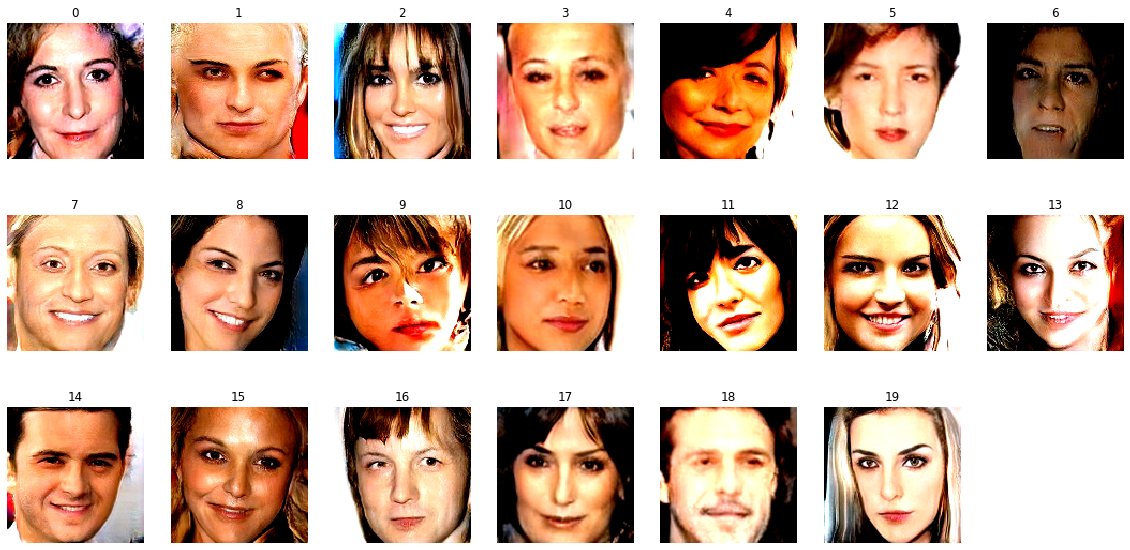

In [9]:
plt.figure(figsize=(20,10))
imgrid(images,cols=7)

Interpolating between two faces using the z_values from the session we ran

In [13]:
num_interps = 10
z_interp = interpolate(z_values[11], z_values[14], num_interps)

In [14]:
images = generate(z_interp)
images = sess.run(images)

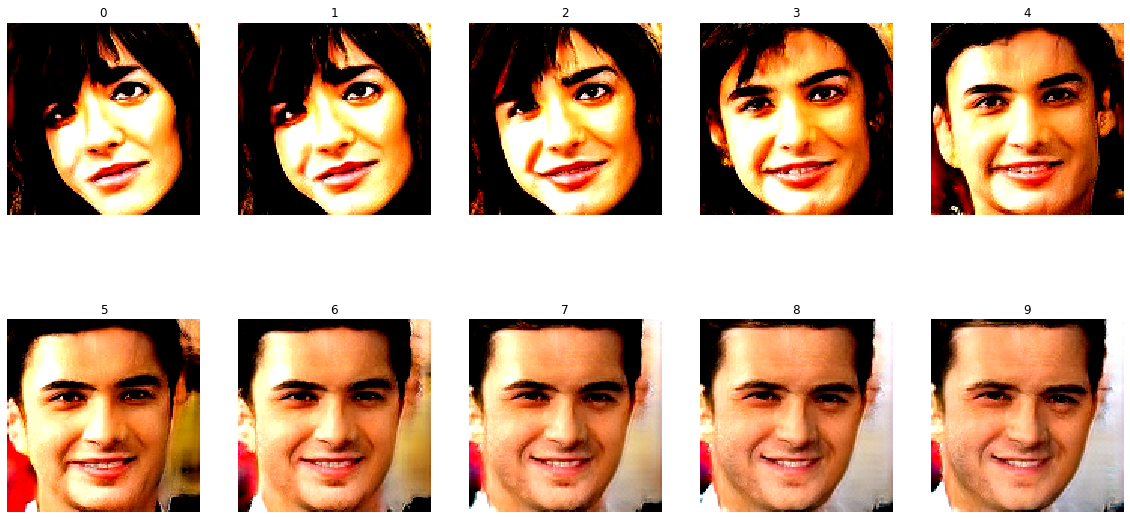

In [15]:
plt.figure(figsize=(20,10))
imgrid(images,cols=5)

# Task 1: 
 1. Pick a face
 2. Take the latent vector and create versions of that vector with some noise added to it, e.g. np.repeat(v, 10, axis=0) + 0.1 * tf.random_normal([10, 512]) - here creating 10 versions of the vector with noise

In [51]:
z_face = np.asarray([z_values[16]])
images = generate(z_face)
images = sess.run(images)

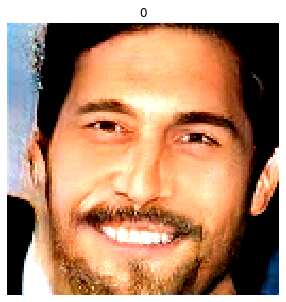

In [52]:
plt.figure(figsize=(10,5))
imgrid(images,cols=1)

In [60]:
z_noisy = np.repeat(z_face, 10, axis=0) + 0.3 * tf.random_normal([10, 512])
# I tried increasing and playing with the amounts of noise to explore the latent space around the z_face I picked

In [61]:
images = generate(z_noisy)
images = sess.run(images)

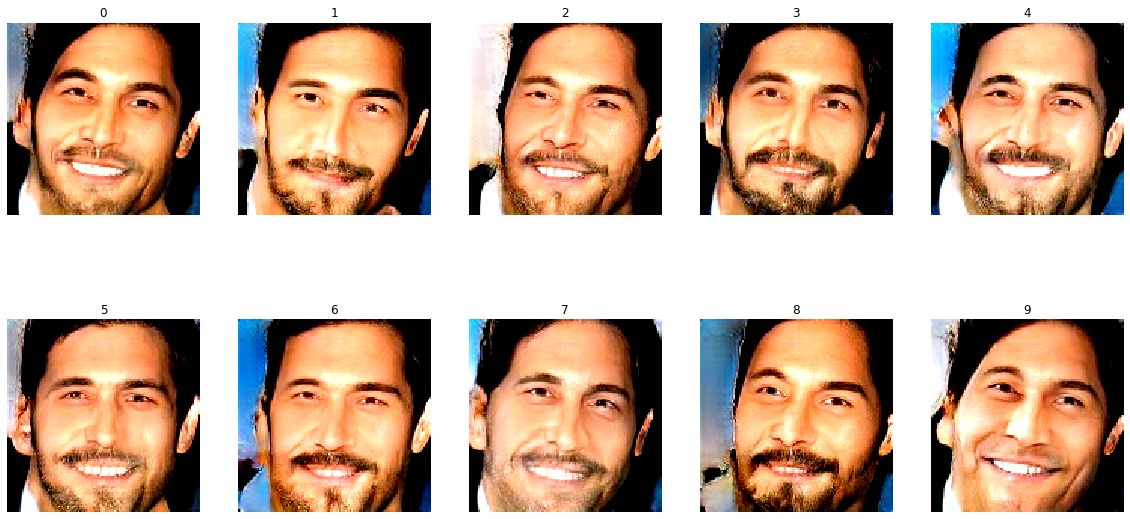

In [63]:
plt.figure(figsize=(20,10))
imgrid(images,cols=5)

# PG GAN from NVidia

In [3]:
import gdown
gdown.download('https://drive.google.com/uc?id=188K19ucknC6wg1R6jbuPEhTq9zoufOx4', None, False)

Downloading...
From: https://drive.google.com/uc?id=188K19ucknC6wg1R6jbuPEhTq9zoufOx4
To: D:\Home\MediaLabs\CourseWork\Pattie_CVGenerativeArtsML\week2_hw\karras2018iclr-celebahq-1024x1024.pkl
277MB [00:26, 10.3MB/s] 


'karras2018iclr-celebahq-1024x1024.pkl'

In [4]:
!wget https://raw.githubusercontent.com/tkarras/progressive_growing_of_gans/master/tfutil.py --no-check-certificate

--2019-10-18 13:49:05--  https://raw.githubusercontent.com/tkarras/progressive_growing_of_gans/master/tfutil.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.20.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.20.133|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 37013 (36K) [text/plain]
Saving to: 'tfutil.py'

     0K .......... .......... .......... ......               100% 2.15M=0.02s

2019-10-18 13:49:05 (2.15 MB/s) - 'tfutil.py' saved [37013/37013]



In [5]:
import tfutil
import pickle

In [6]:
tf.reset_default_graph()

In [7]:
sess = tf.Session()

In [8]:
# Import network.
with sess.as_default():
    with open('karras2018iclr-celebahq-1024x1024.pkl', 'rb') as file:
        G, D, Gs = pickle.load(file)

W1018 13:49:23.104754  1292 deprecation_wrapper.py:119] From D:\Home\MediaLabs\CourseWork\Pattie_CVGenerativeArtsML\week2_hw\tfutil.py:468: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1018 13:49:23.105751  1292 deprecation_wrapper.py:119] From D:\Home\MediaLabs\CourseWork\Pattie_CVGenerativeArtsML\week2_hw\tfutil.py:471: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1018 13:49:23.106768  1292 deprecation_wrapper.py:119] From D:\Home\MediaLabs\CourseWork\Pattie_CVGenerativeArtsML\week2_hw\tfutil.py:471: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W1018 13:49:23.107747  1292 deprecation_wrapper.py:119] From D:\Home\MediaLabs\CourseWork\Pattie_CVGenerativeArtsML\week2_hw\tfutil.py:472: The name tf.get_variable_scope is deprecated. Please use tf.compat.v1.get_variable_scope instead.

W1018 13:49:23.108744  1292 deprecation_wrapper.py:119] From D:\Home\M

# Task2:
### Generate more faces

In [20]:
# Generate latent vectors.
latents = np.random.RandomState(1000).randn(1000, *Gs.input_shapes[0][1:]) # 1000 random latents
# hand-picked top-10
#latents = latents[[477, 56, 83, 887, 583, 391, 86, 340, 341, 415]] 
latents = latents[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]] 

# Generate dummy labels (not used by the official networks).
labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])

In [21]:
with sess.as_default():
    # Run the generator to produce a set of images.
    images = Gs.run(latents, labels, num_gpus=1)

images = np.clip(np.rint((images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8) # [-1,1] => [0,255]
images = images.transpose(0, 2, 3, 1) # NCHW => NHWC

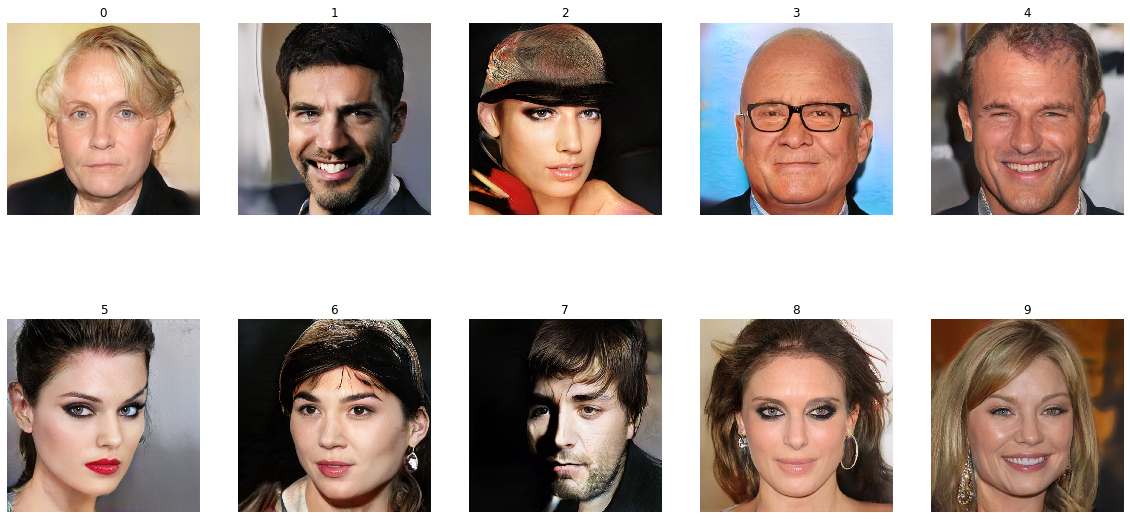

In [22]:
plt.figure(figsize=(20,10))
imgrid(images)

# Task3:
### Interpolate between 2 faces

In [26]:
z_interp = interpolate(latents[3], latents[9], 10)
z_interp.shape

(10, 512)

In [27]:
with sess.as_default():
    # Generate dummy labels (not used by the official networks).
    labels = np.zeros([z_interp.shape[0]] + Gs.input_shapes[1][1:])

    # Run the generator to produce a set of images.
    images = Gs.run(z_interp, labels, num_gpus=1)

    images = np.clip(np.rint((images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8) # [-1,1] => [0,255]
    images = images.transpose(0, 2, 3, 1) # NCHW => NHWC   

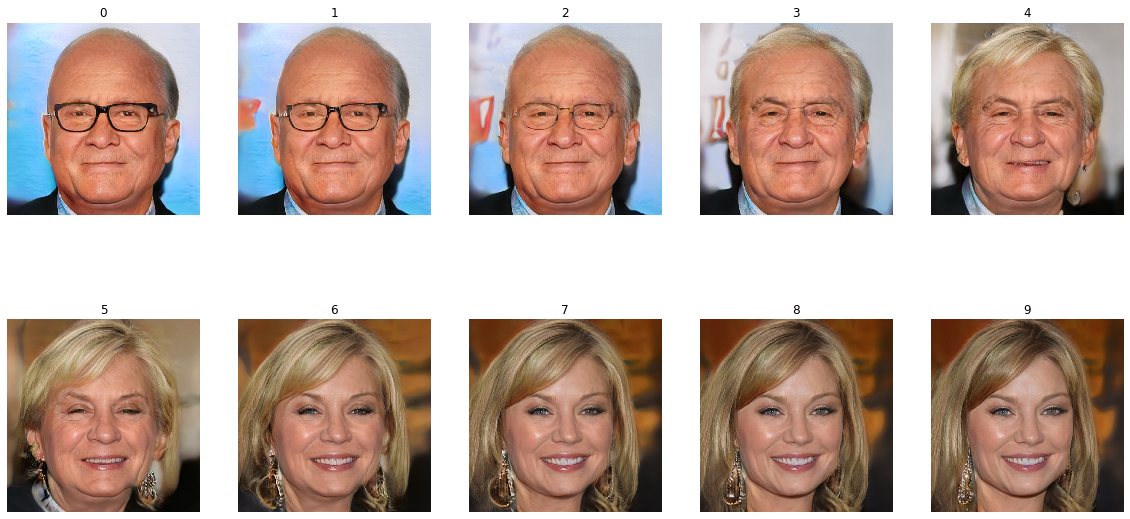

In [28]:
plt.figure(figsize=(20,10))
imgrid(images, cols=5)

# Task3:
### Generate more noise variants of a single face

In [29]:
latent_face = np.asarray([latents[4]])
labels = np.zeros([latent_face.shape[0]] + Gs.input_shapes[1][1:])

In [34]:
with sess.as_default():
    # Run the generator to produce a set of images.
    images = Gs.run(latent_face, labels, num_gpus=1)

images = np.clip(np.rint((images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8) # [-1,1] => [0,255]
images = images.transpose(0, 2, 3, 1) # NCHW => NHWC

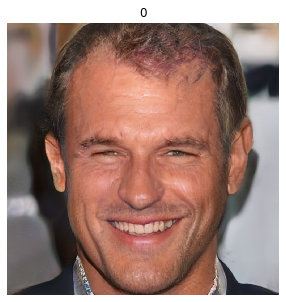

In [37]:
plt.figure(figsize=(10,5))
imgrid(images, cols=1)

In [59]:
latent_noisy = np.repeat(latent_face, 10, axis=0) + 0.1 * np.random.normal(0,5,[10, 512])
# I tried increasing and playing with the amounts of noise to explore the latent space around the z_face I picked

labels = np.zeros([latent_noisy.shape[0]] + Gs.input_shapes[1][1:])

In [57]:
with sess.as_default():
    # Run the generator to produce a set of images.
    images = Gs.run(latent_noisy, labels, num_gpus=1)

images = np.clip(np.rint((images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8) # [-1,1] => [0,255]
images = images.transpose(0, 2, 3, 1) # NCHW => NHWC

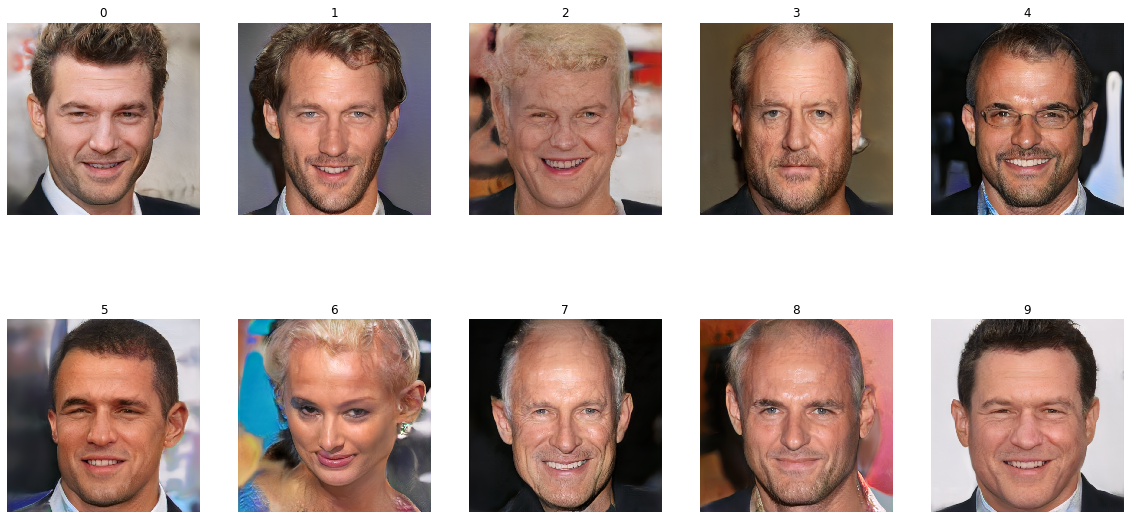

In [58]:
plt.figure(figsize=(20,10))
imgrid(images, cols=5)